<a href="https://colab.research.google.com/github/Hound36114/START-OF-PROJECTS/blob/main/Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
train_data, validation_data, test_data = tfds.load(name = 'imdb_reviews',
                                                  split = ('train[:60%]', 'train[60%:]', 'test'),
                                                  as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XMCUG8_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XMCUG8_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XMCUG8_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [10]:

def test_data_shapes():
    """Ensure train batches are not empty and labels exist"""
    for batch, label in train_data.batch(10).take(1):
        batch_tensor = tf.convert_to_tensor(batch)
        label_tensor = tf.convert_to_tensor(label)
        assert tf.shape(batch_tensor)[0] > 0
        assert tf.shape(label_tensor)[0] > 0

In [11]:
test_data_shapes()

In [12]:
def test_label_values():
    """Check labels are only 0 or 1"""
    # Take a batch of 10 labels to make it a proper tensor
    for _, label in train_data.batch(10).take(1):
        label_tensor = tf.convert_to_tensor(label)      # Ensure it's a proper tensor
        unique_labels = tf.unique(label_tensor)[0].numpy()  # Get unique labels
        assert set(unique_labels).issubset({0, 1})     # Check only 0 or 1

In [13]:
test_label_values()

In [3]:
train_example_batch, train_labels_batch = next(iter(train_data.batch(10)))

In [4]:
train_example_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [5]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [6]:
class HubWrapper(tf.keras.layers.Layer):
  #Wraps a TensorFlow‑Hub SavedModel so Keras3 sees it as a regular Layer.

  def __init__(self, url: str, trainable: bool = False, **kwargs):
    super().__init__(trainable = trainable, **kwargs)
    self.url = url
    self._hub_model = None #lazy-load in build()

  def build(self, input_shape):
    self._hub_model = hub.load(self.url)
    self._hub_model = tf.function(self._hub_model)
    super().build(input_shape)

  def call(self, inputs):
    outputs = self._hub_model(inputs)

    if isinstance(outputs, dict):
      outputs = outputs.get("default", list(outputs.values())[0])

    return outputs

In [7]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = HubWrapper(embedding, dtype = tf.string, trainable = True, name = "text_embedding")

In [8]:
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(16, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_embedding (HubWrapper)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
def test_model_output_range():
    """Ensure model output is in 0-1 range"""
    sample_text = tf.constant(["Amazing movie", "Terrible acting"])
    pred = model(sample_text)
    assert tf.reduce_max(pred) <= 1.0
    assert tf.reduce_min(pred) >= 0.0


In [15]:
test_model_output_range()

In [16]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [17]:

history = model.fit(train_data.shuffle(10000).batch(100),
                    epochs = 25,
                    validation_data = validation_data.batch(100),
                    verbose = 1)

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5518 - loss: 0.9339 - val_accuracy: 0.6559 - val_loss: 0.6150
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6769 - loss: 0.6041 - val_accuracy: 0.6907 - val_loss: 0.5874
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6937 - loss: 0.5843 - val_accuracy: 0.6979 - val_loss: 0.5773
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7029 - loss: 0.5722 - val_accuracy: 0.7089 - val_loss: 0.5690
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7071 - loss: 0.5649 - val_accuracy: 0.7083 - val_loss: 0.5665
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7114 - loss: 0.5616 - val_accuracy: 0.7119 - val_loss: 0.5643
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7138 - loss: 0.5573 - val_accuracy: 0.7151 - val_loss: 0.5614
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7157 - loss: 0.5574 - val_accuracy: 0.711

In [18]:
results = model.evaluate(test_data.batch(100), verbose = 2)

250/250 - 6s - 23ms/step - accuracy: 0.7170 - loss: 0.5521


In [19]:
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.552
compile_metrics: 0.717


In [20]:
def test_accuracy_reasonable():
    """Check that model achieves reasonable accuracy on test set"""
    results = model.evaluate(test_data.batch(100), verbose=0)
    accuracy = results[1]
    assert accuracy > 0.5


In [21]:
test_accuracy_reasonable()

In [22]:
import matplotlib.pyplot as plt
def plot_class_distribution():
    pos_count = 0
    neg_count = 0
    for _, label in train_data.take(1000):  # check first 1000 reviews
        if label.numpy() == 1:
            pos_count += 1
        else:
            neg_count += 1

    plt.bar(['Positive', 'Negative'], [pos_count, neg_count], color=['green', 'red'])
    plt.title("Class Distribution in Sample of 1000 Reviews")
    plt.ylabel("Number of Reviews")
    plt.show()

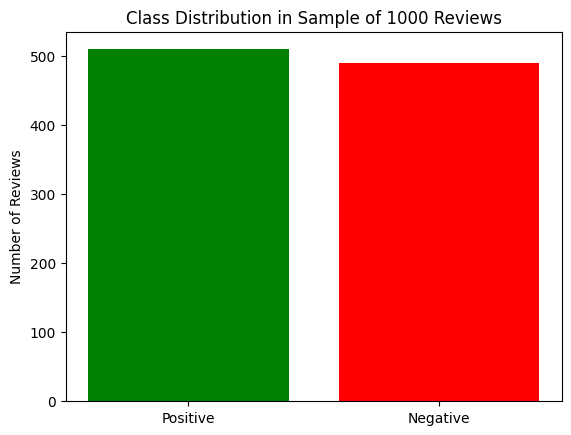

In [23]:
plot_class_distribution()